In [1]:
import os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Flatten, Dense, UpSampling2D, Reshape
import tensorflow_probability as tfp

import matplotlib.pyplot as plt

In [2]:
data_folder = "dataset/celebA/"

In [3]:
attr_df = pd.read_csv(data_folder+'list_attr_celeba.csv')
attr_df = attr_df.replace(to_replace = -1, value = 0)

In [4]:
tfd = tfp.distributions
tfpl = tfp.layers
tfb = tfp.bijectors

In [5]:
def load_dataset(data_dir, img_size = 32, batch_size = 1):
    df = tf.keras.utils.image_dataset_from_directory(directory = data_dir, 
                                                     labels = None, 
                                                     validation_split = 0.99,
                                                     image_size = (img_size, img_size),
                                                     batch_size = batch_size,
                                                     subset =  'training',
                                                     seed = 42
                                                    )
    df = df.map(lambda x : x/255.0)
    df = df.map(lambda x: (x, x))
    return df

In [6]:
img_size = 64
train_ds = load_dataset(data_folder+"img_align_celeba", img_size = img_size)

Found 202599 files belonging to 1 classes.
Using 2026 files for training.
Metal device set to: Apple M2


2023-03-17 01:17:15.097742: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-17 01:17:15.097896: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
def get_prior(num_modes, latent_dim):
    prior = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=[1 / num_modes,] * num_modes),
        components_distribution=tfd.MultivariateNormalDiag(
            loc=tf.Variable(tf.random.normal(shape=[num_modes, latent_dim])),
            scale_diag=tfp.util.TransformedVariable(tf.Variable(tf.ones(shape=[num_modes, latent_dim])), bijector=tfb.Softplus())
        )
    )
    return prior

In [8]:
def get_kl_regularizer(prior_distribution):
    divergence_regularizer = tfpl.KLDivergenceRegularizer(
        prior_distribution,
        use_exact_kl=False,
        weight=1.0,
        test_points_fn=lambda q: q.sample(3),
        test_points_reduce_axis=(0, 1)
    )
    return divergence_regularizer

In [9]:
prior = get_prior(num_modes=2, latent_dim=50)
kl_regularizer = get_kl_regularizer(prior)

In [10]:
def reconstruction_loss(batch_of_images, decoding_dist):
    """
    The function takes batch_of_images (Tensor containing a batch of input images to
    the encoder) and decoding_dist (output distribution of decoder after passing the 
    image batch through the encoder and decoder) as arguments.
    The function should return the scalar average expected reconstruction loss.
    """
    return -tf.reduce_mean(decoding_dist.log_prob(batch_of_images), axis=0)

In [15]:
def get_encoder(latent_dim, kl_regularizer):
    encoder = Sequential([
        Conv2D(32, (4, 4), activation='relu', strides=2, padding='SAME', input_shape=(img_size, img_size, 3)),
        BatchNormalization(),
        Conv2D(64, (4, 4), activation='relu', strides=2, padding='SAME'),
        BatchNormalization(),
        Conv2D(128, (4, 4), activation='relu', strides=2, padding='SAME'),
        BatchNormalization(),
        Conv2D(256, (4, 4), activation='relu', strides=2, padding='SAME'),
        BatchNormalization(),
        Flatten(),
        Dense(tfpl.MultivariateNormalTriL.params_size(latent_dim)),
        tfpl.MultivariateNormalTriL(latent_dim, activity_regularizer=kl_regularizer)
    ])
    return encoder

def get_decoder(latent_dim):
    decoder = Sequential([
        Dense(4096, activation='relu', input_shape=(latent_dim, )),
        Reshape((4, 4, 256)),
        UpSampling2D(size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu', padding='SAME'),
        UpSampling2D(size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu', padding='SAME'),
        UpSampling2D(size=(2, 2)),
        Conv2D(32, (3, 3), activation='relu', padding='SAME'),
        UpSampling2D(size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu', padding='SAME'),
        Conv2D(3, (3, 3), padding='SAME'),
        Flatten(),
        tfpl.IndependentBernoulli(event_shape=(img_size, img_size, 3))
    ])
    return decoder

encoder = get_encoder(latent_dim=50, kl_regularizer=kl_regularizer)
decoder = get_decoder(latent_dim=50)
vae = Model(inputs=encoder.inputs, outputs=decoder(encoder.outputs))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer, loss=reconstruction_loss)

In [16]:
_ = vae.fit(train_ds, epochs=20)

Epoch 1/20


2023-03-17 01:20:27.460676: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2026/2026 [==============================] - 87s 41ms/step - loss: 9216.7002
Epoch 2/20
2026/2026 [==============================] - 75s 37ms/step - loss: 7499.3491
Epoch 3/20
2026/2026 [==============================] - 74s 36ms/step - loss: 7070.4102
Epoch 4/20
2026/2026 [==============================] - 78s 38ms/step - loss: 6910.8213
Epoch 5/20
2026/2026 [==============================] - 78s 38ms/step - loss: 6847.5933
Epoch 6/20
2026/2026 [==============================] - 75s 37ms/step - loss: 6800.1392
Epoch 7/20
2026/2026 [==============================] - 76s 38ms/step - loss: 6758.8208
Epoch 8/20
2026/2026 [==============================] - 80s 39ms/step - loss: 6724.7544
Epoch 9/20
2026/2026 [==============================] - 177s 87ms/step - loss: 6696.9102
Epoch 10/20
2026/2026 [==============================] - 3543s 2s/step - loss: 6680.7661
Epoch 11/20
2026/2026 [==============================] - 5063s 3s/step - loss: 6660.8882
Epoch 12/20
2026/2026 [=================

In [17]:
def generate_images(prior, decoder, n_samples):
    """
    The function takes the prior distribution, decoder and number of samples as inputs, which
    should be used to generate the images.
    The function should then return the batch of generated images.
    """
    z = prior.sample(n_samples)
    return decoder(z).mean()

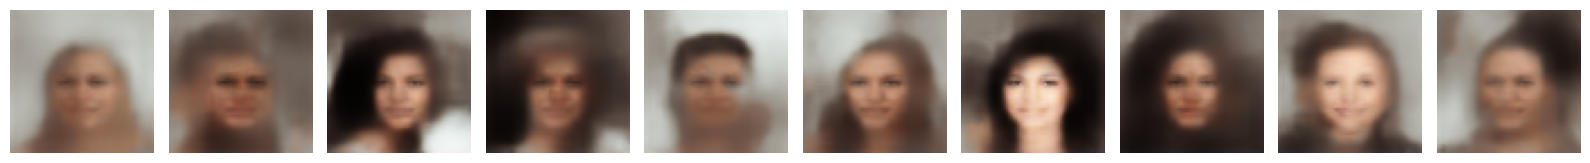

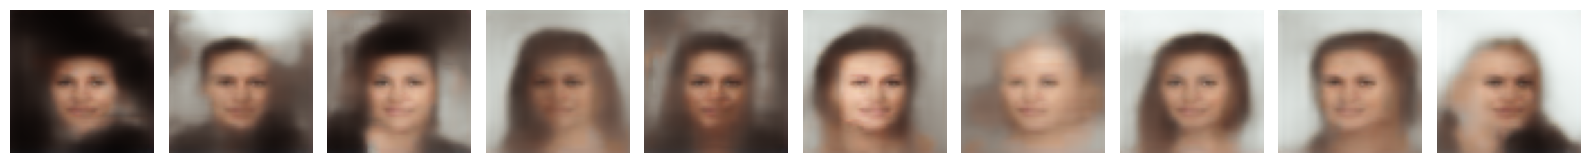

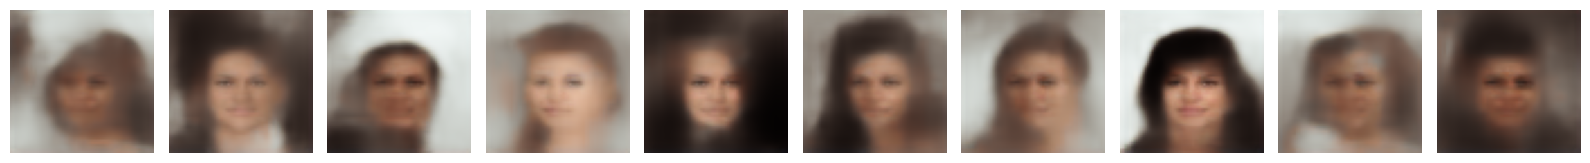

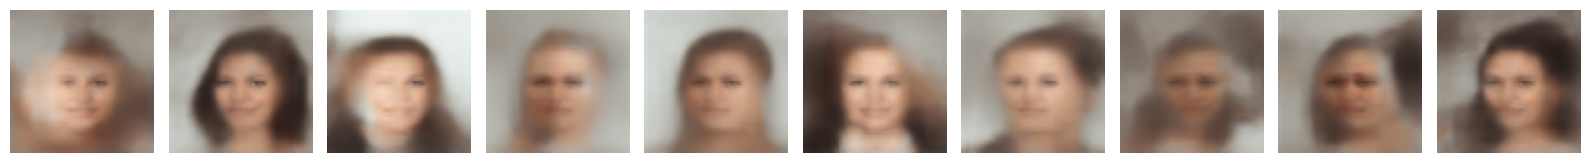

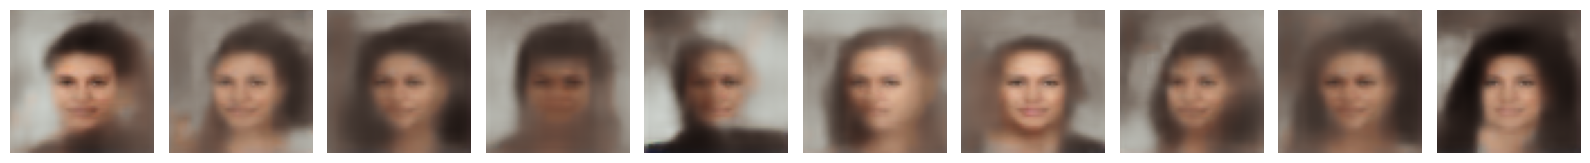

In [18]:
n_samples = 10

for i in range(5):
    f, axs = plt.subplots(1, n_samples, figsize=(16, 6))
    sampled_images = generate_images(prior, decoder, n_samples)
    for j in range(n_samples):
        axs[j].imshow(sampled_images[j])
        axs[j].axis('off')

    plt.tight_layout()